# Debiasing with Propensity Score: IPTW Mechanics

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A3 | Notebook 1 of 2**

This notebook covers the mechanics of inverse probability of treatment
weighting (IPTW) for debiasing observational data, with comparison
between stored and estimated propensity scores.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

---

## 1. Intuition {#intuition}

### The Email Marketing Problem

**Scenario**: Financial company testing marketing emails for new advisory service.

- Three emails: `em1`, `em2`, `em3` with different targeting
- Assignment based on customer characteristics (age, income, investments)
- Outcome: Whether customer converts to new service

**Key insight**: Marketing team stored the assignment probabilities!

### Why Propensity Score Debiasing?

**Alternative to orthogonalization**:
- Orthogonalization: Residualize both T and Y on X
- PS debiasing: Reweight sample by inverse treatment probability

**When to prefer PS**:
1. **Stored probabilities**: No model needed → no estimation error
2. **Binary/categorical treatment**: PS best defined for discrete T
3. **Balance diagnostics**: Easy to check if debiasing worked

### The Core Idea

**Weight by inverse probability of what you got**:

- If treated: weight = 1/P(T=1|X)
- If control: weight = 1/P(T=0|X) = 1/(1-P(T=1|X))

**Why this works**:
- High-propensity treated units are downweighted (common)
- Low-propensity treated units are upweighted (rare, like controls)
- Creates "pseudo-population" where T ⊥ X

```
★ Insight ─────────────────────────────────────────────────────
IPTW upsamples:
- Treated units that look like controls (low PS)
- Control units that look like treated (high PS)

These are exactly the units needed for counterfactual estimation!
──────────────────────────────────────────────────────────────
```

---

## 2. Formal Treatment {#formal}

### 2.1 Propensity Score Definition

For binary treatment:
$$e(X) = P(T=1|X)$$

For categorical treatment with K levels:
$$e_k(X) = P(T=k|X) \quad \text{for } k = 0, 1, ..., K$$

### 2.2 IPTW Weights

**Binary treatment**:
$$W_i = \frac{T_i}{e(X_i)} + \frac{1-T_i}{1-e(X_i)}$$

**Categorical treatment**:
$$W_i = \sum_{k=0}^{K} \frac{\mathbf{1}\{T_i=k\}}{e_k(X_i)}$$

### 2.3 Identification Result

**Theorem (Horvitz-Thompson)**:

Under conditional ignorability $(Y(0), Y(1)) \perp T | X$ and positivity $0 < e(X) < 1$:

$$E\left[\frac{Y \cdot T}{e(X)}\right] = E[Y(1)]$$

$$E\left[\frac{Y \cdot (1-T)}{1-e(X)}\right] = E[Y(0)]$$

**Proof sketch**:

\begin{align}
E\left[\frac{Y \cdot T}{e(X)}\right] &= E\left[E\left[\frac{Y \cdot T}{e(X)} \Bigg| X\right]\right] \\
&= E\left[\frac{1}{e(X)} E[Y \cdot T | X]\right] \\
&= E\left[\frac{1}{e(X)} E[Y | T=1, X] \cdot P(T=1|X)\right] \\
&= E\left[\frac{1}{e(X)} E[Y(1) | X] \cdot e(X)\right] \\
&= E[E[Y(1)|X]] = E[Y(1)]
\end{align}

### 2.4 ATE Estimator

$$\hat{\tau}_{IPTW} = \frac{1}{n}\sum_{i=1}^{n} \frac{Y_i T_i}{e(X_i)} - \frac{1}{n}\sum_{i=1}^{n} \frac{Y_i (1-T_i)}{1-e(X_i)}$$

### 2.5 Normalized Weights

**Hajek estimator** (normalized IPTW):

$$\hat{\tau}_{Hajek} = \frac{\sum_i Y_i T_i / e(X_i)}{\sum_i T_i / e(X_i)} - \frac{\sum_i Y_i (1-T_i) / (1-e(X_i))}{\sum_i (1-T_i) / (1-e(X_i))}$$

- More stable (weights sum to n)
- Slightly biased but lower variance
- Recommended in practice

```
★ Key Result ──────────────────────────────────────────────────
IPTW achieves balance: In the pseudo-population,

$$E[X | T=1] \approx E[X | T=0]$$

Treatment becomes "as good as random" after weighting.
──────────────────────────────────────────────────────────────
```

---

## 3. Numeric Demonstration {#numeric}

### Email Marketing Data

In [2]:
# Load or simulate email marketing data
try:
    email = load_facure_data('invest_email')
    print("Loaded invest_email.csv from Facure data")
except:
    # Simulate data
    print("Generating simulated email data...")
    np.random.seed(42)
    n = 5000
    
    # Customer characteristics
    age = np.random.uniform(25, 55, n)
    income = np.random.exponential(5000, n)
    insurance = np.random.exponential(20000, n)
    invested = np.random.exponential(10000, n)
    
    # Propensity scores (stored from experiment design)
    # em1 targets mass market (lower income, less invested)
    em1_ps = 1 / (1 + np.exp(0.001*income + 0.0001*invested - 3))
    em1_ps = np.clip(em1_ps, 0.02, 0.98)
    
    # Treatment assignment based on stored PS
    em1 = np.random.binomial(1, em1_ps)
    
    # Outcome: conversion (depends on age, slightly on treatment)
    # True treatment effect = 0.05
    convert_prob = 1 / (1 + np.exp(-0.1*age + 0.0001*income - 0.05*em1 - 2))
    converted = np.random.binomial(1, convert_prob)
    
    email = pd.DataFrame({
        'age': age,
        'income': income,
        'insurance': insurance,
        'invested': invested,
        'em1_ps': em1_ps,
        'em1': em1,
        'converted': converted
    })

print(f"\nData shape: {email.shape}")
email.head()

Generating simulated email data...

Data shape: (5000, 7)


,age,income,insurance,invested,em1_ps,em1,converted
0,36.2362,2501.3701,9356.6260,6924.8789,0.4517,1,1
1,53.5214,3206.9088,8096.6690,13733.6539,0.1708,0,1
2,46.9598,9639.5249,3875.4311,8270.5986,0.0200,0,1
3,42.9598,2077.6104,18692.4889,869.7783,0.6975,1,1
4,29.6806,10187.6486,12949.1090,2052.7937,0.0200,0,1


In [3]:
# Define confounders
confounders = ['age', 'income', 'insurance', 'invested']

# Check confounding: correlations with treatment and outcome
print("Correlations with treatment (em1) and outcome (converted):")
print("-" * 50)
corr_df = email[confounders + ['em1', 'converted']].corr()[['em1', 'converted']]
print(corr_df.round(3))

Correlations with treatment (em1) and outcome (converted):
--------------------------------------------------
              em1  converted
age        0.0100     0.0700
income    -0.4630    -0.0410
insurance  0.0090     0.0050
invested  -0.1950     0.0220
em1        1.0000    -0.0080
converted -0.0080     1.0000


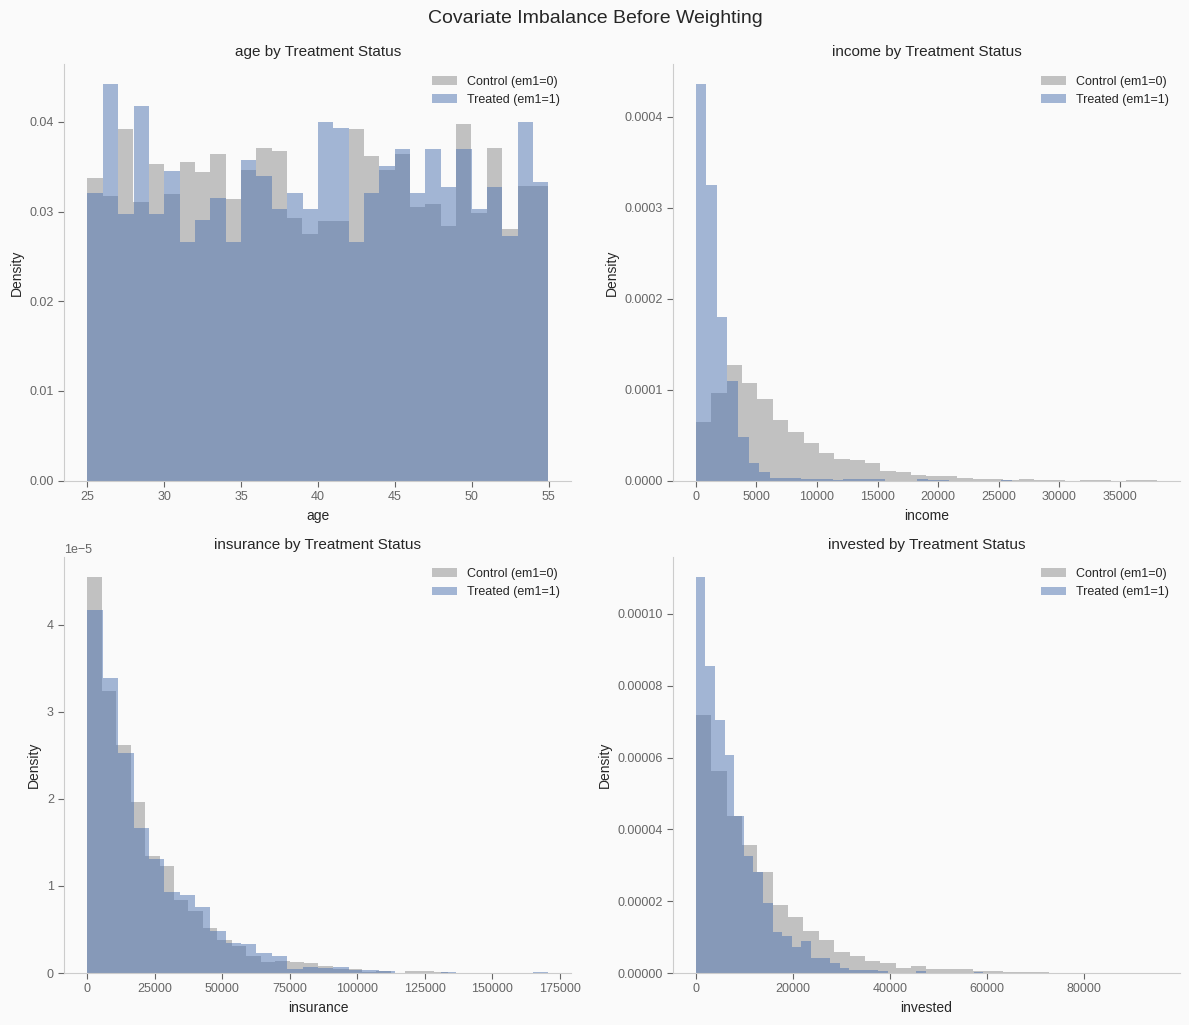

In [4]:
# Visualize confounding: distribution by treatment status
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, var in enumerate(confounders):
    ax = axes[i // 2, i % 2]
    
    for em1_val, color, label in [(0, COLORS['gray'], 'Control (em1=0)'), 
                                   (1, COLORS['blue'], 'Treated (em1=1)')]:
        subset = email[email['em1'] == em1_val][var]
        ax.hist(subset, bins=30, alpha=0.5, color=color, label=label, density=True)
    
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.set_title(f'{var} by Treatment Status')
    ax.legend()
    apply_tufte_style(ax)

plt.tight_layout()
plt.suptitle('Covariate Imbalance Before Weighting', y=1.02, fontsize=14)
plt.show()

### Naive Estimate (Biased)

In [5]:
# Naive difference in means
treated_mean = email[email['em1'] == 1]['converted'].mean()
control_mean = email[email['em1'] == 0]['converted'].mean()
naive_ate = treated_mean - control_mean

print("Naive Analysis (Ignoring Confounding):")
print(f"  Treated conversion rate: {treated_mean:.3f}")
print(f"  Control conversion rate: {control_mean:.3f}")
print(f"  Naive ATE: {naive_ate:.4f}")
print("\n  Warning: This is biased due to confounding!")

Naive Analysis (Ignoring Confounding):
  Treated conversion rate: 0.993
  Control conversion rate: 0.995
  Naive ATE: -0.0013



---

## 4. Implementation {#implementation}

### IPTW with Stored Propensity Scores

In [6]:
def compute_iptw_weights(treatment, propensity_score):
    """
    Compute IPTW weights for binary treatment.
    
    Parameters
    ----------
    treatment : array
        Binary treatment indicator (0 or 1)
    propensity_score : array
        Probability of treatment given covariates
        
    Returns
    -------
    array
        IPTW weights
    """
    weights = np.where(
        treatment == 1,
        1 / propensity_score,
        1 / (1 - propensity_score)
    )
    return weights


def iptw_ate(outcome, treatment, propensity_score, normalized=True):
    """
    Estimate ATE using IPTW.
    
    Parameters
    ----------
    outcome : array
        Outcome variable
    treatment : array
        Binary treatment indicator
    propensity_score : array
        Propensity scores
    normalized : bool
        If True, use Hajek estimator (normalized weights)
        
    Returns
    -------
    dict
        ate, mu1, mu0
    """
    T = np.asarray(treatment)
    Y = np.asarray(outcome)
    e = np.asarray(propensity_score)
    
    if normalized:
        # Hajek estimator
        mu1 = np.sum(Y * T / e) / np.sum(T / e)
        mu0 = np.sum(Y * (1 - T) / (1 - e)) / np.sum((1 - T) / (1 - e))
    else:
        # Horvitz-Thompson estimator
        n = len(Y)
        mu1 = np.sum(Y * T / e) / n
        mu0 = np.sum(Y * (1 - T) / (1 - e)) / n
    
    return {
        'ate': mu1 - mu0,
        'mu1': mu1,
        'mu0': mu0
    }

# IPTW with stored propensity scores
result_stored = iptw_ate(
    email['converted'], 
    email['em1'], 
    email['em1_ps'],
    normalized=True
)

print("IPTW with Stored Propensity Scores:")
print(f"  E[Y(1)]: {result_stored['mu1']:.4f}")
print(f"  E[Y(0)]: {result_stored['mu0']:.4f}")
print(f"  ATE: {result_stored['ate']:.4f}")

IPTW with Stored Propensity Scores:
  E[Y(1)]: 0.9952
  E[Y(0)]: 0.9941
  ATE: 0.0010


### Resampling Approach (Create Debiased Dataset)

In [7]:
def create_debiased_dataset(data, treatment_col, ps_col, n_samples=10000, seed=42):
    """
    Create debiased dataset by resampling with IPTW weights.
    
    Parameters
    ----------
    data : pd.DataFrame
        Original dataset
    treatment_col : str
        Treatment column name
    ps_col : str
        Propensity score column name
    n_samples : int
        Number of samples to draw
    seed : int
        Random seed
        
    Returns
    -------
    pd.DataFrame
        Resampled dataset
    """
    np.random.seed(seed)
    
    # Compute weights
    weights = compute_iptw_weights(data[treatment_col], data[ps_col])
    
    # Normalize weights for sampling
    weights_normalized = weights / weights.sum()
    
    # Resample with replacement
    indices = np.random.choice(
        len(data), size=n_samples, replace=True, p=weights_normalized
    )
    
    return data.iloc[indices].reset_index(drop=True)

# Create debiased dataset
email_debiased = create_debiased_dataset(email, 'em1', 'em1_ps', n_samples=10000)

print(f"Original dataset: {len(email)} rows")
print(f"Debiased dataset: {len(email_debiased)} rows")

Original dataset: 5000 rows
Debiased dataset: 10000 rows


In [8]:
# Check balance in debiased dataset
print("Correlations BEFORE debiasing:")
print(email[confounders + ['em1']].corr()['em1'].round(3))

print("\nCorrelations AFTER debiasing:")
print(email_debiased[confounders + ['em1']].corr()['em1'].round(3))

Correlations BEFORE debiasing:
age          0.0100
income      -0.4630
insurance    0.0090
invested    -0.1950
em1          1.0000
Name: em1, dtype: float64

Correlations AFTER debiasing:
age          0.0530
income       0.0630
insurance   -0.0140
invested     0.0410
em1          1.0000
Name: em1, dtype: float64


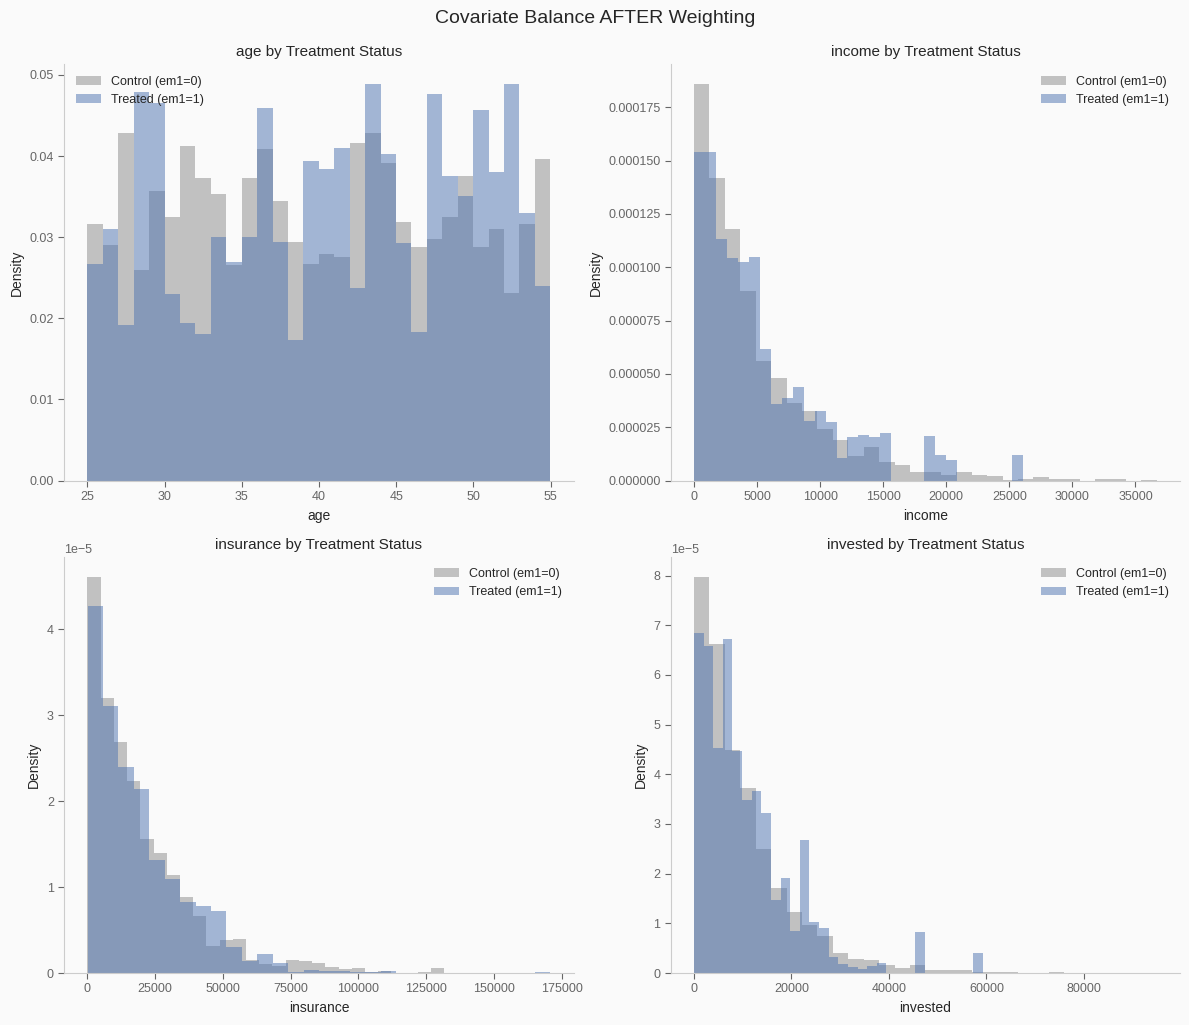

In [9]:
# Visualize balance improvement
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, var in enumerate(confounders):
    ax = axes[i // 2, i % 2]
    
    for em1_val, color, label in [(0, COLORS['gray'], 'Control (em1=0)'), 
                                   (1, COLORS['blue'], 'Treated (em1=1)')]:
        subset = email_debiased[email_debiased['em1'] == em1_val][var]
        ax.hist(subset, bins=30, alpha=0.5, color=color, label=label, density=True)
    
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.set_title(f'{var} by Treatment Status')
    ax.legend()
    apply_tufte_style(ax)

plt.tight_layout()
plt.suptitle('Covariate Balance AFTER Weighting', y=1.02, fontsize=14)
plt.show()

### IPTW with Estimated Propensity Scores

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict

def estimate_propensity_score(X, T, n_folds=5, seed=42):
    """
    Estimate propensity scores using calibrated classifier with cross-validation.
    
    Parameters
    ----------
    X : array or DataFrame
        Covariates
    T : array
        Binary treatment
    n_folds : int
        Number of cross-validation folds
    seed : int
        Random seed
        
    Returns
    -------
    array
        Estimated propensity scores
    """
    np.random.seed(seed)
    
    # Calibrated classifier
    base_clf = RandomForestClassifier(
        n_estimators=100, max_depth=3, min_samples_leaf=40, random_state=seed
    )
    clf = CalibratedClassifierCV(base_clf, cv=3)
    
    # Cross-validated predictions
    ps_estimated = cross_val_predict(clf, X, T, cv=n_folds, method='predict_proba')[:, 1]
    
    return ps_estimated

# Estimate propensity scores
X = email[confounders]
T = email['em1']

ps_estimated = estimate_propensity_score(X, T)

# Compare stored vs estimated
email_compare = email.assign(ps_estimated=ps_estimated)

print("Propensity Score Comparison:")
print(f"  Correlation (stored vs estimated): {np.corrcoef(email['em1_ps'], ps_estimated)[0,1]:.3f}")
print(f"  Mean absolute difference: {np.mean(np.abs(email['em1_ps'] - ps_estimated)):.4f}")

Propensity Score Comparison:
  Correlation (stored vs estimated): 0.974
  Mean absolute difference: 0.0575


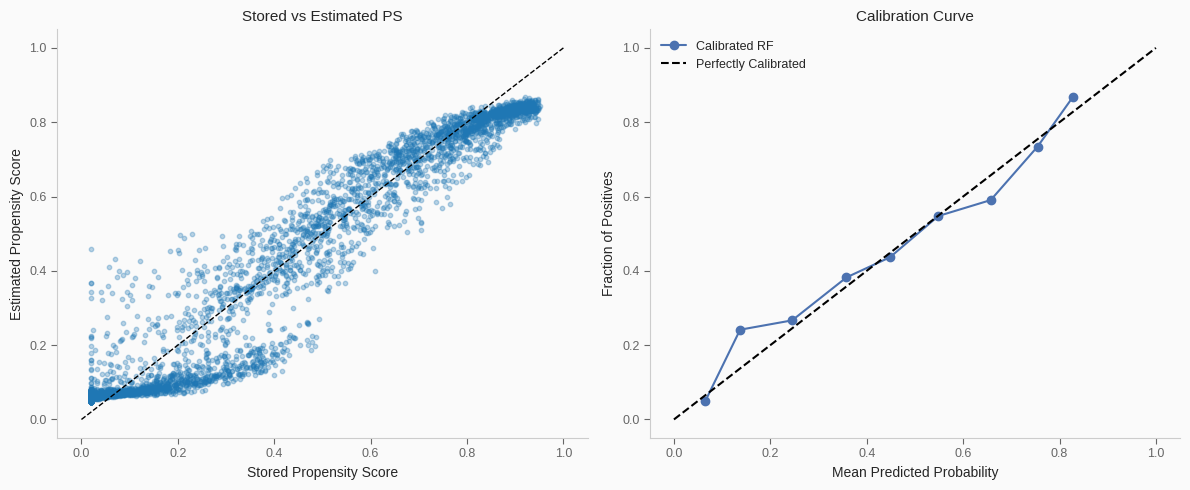

In [11]:
# Visualize PS comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
ax = axes[0]
ax.scatter(email['em1_ps'], ps_estimated, alpha=0.3, s=10)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax.set_xlabel('Stored Propensity Score')
ax.set_ylabel('Estimated Propensity Score')
ax.set_title('Stored vs Estimated PS')
apply_tufte_style(ax)

# Calibration curve
from sklearn.calibration import calibration_curve
ax = axes[1]
prob_true, prob_pred = calibration_curve(T, ps_estimated, n_bins=10)
ax.plot(prob_pred, prob_true, 'o-', color=COLORS['blue'], label='Calibrated RF')
ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title('Calibration Curve')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

In [12]:
# IPTW with estimated PS
result_estimated = iptw_ate(
    email['converted'], 
    email['em1'], 
    ps_estimated,
    normalized=True
)

# Compare results
print("Comparison of IPTW Estimates:")
print("-" * 50)
print(f"Naive (no adjustment):        {naive_ate:.4f}")
print(f"IPTW with stored PS:          {result_stored['ate']:.4f}")
print(f"IPTW with estimated PS:       {result_estimated['ate']:.4f}")

Comparison of IPTW Estimates:
--------------------------------------------------
Naive (no adjustment):        -0.0013
IPTW with stored PS:          0.0010
IPTW with estimated PS:       -0.0003


In [13]:
# Check balance with estimated PS
email_debiased_est = create_debiased_dataset(
    email.assign(ps_est=ps_estimated), 'em1', 'ps_est', n_samples=10000
)

print("Balance Check (Correlations with em1):")
print("-" * 50)
print("Original:")
print(email[confounders + ['em1']].corr()['em1'].round(3))
print("\nDebiased with Stored PS:")
print(email_debiased[confounders + ['em1']].corr()['em1'].round(3))
print("\nDebiased with Estimated PS:")
print(email_debiased_est[confounders + ['em1']].corr()['em1'].round(3))

Balance Check (Correlations with em1):
--------------------------------------------------
Original:
age          0.0100
income      -0.4630
insurance    0.0090
invested    -0.1950
em1          1.0000
Name: em1, dtype: float64

Debiased with Stored PS:
age          0.0530
income       0.0630
insurance   -0.0140
invested     0.0410
em1          1.0000
Name: em1, dtype: float64

Debiased with Estimated PS:
age          0.0310
income      -0.1650
insurance   -0.0080
invested    -0.0990
em1          1.0000
Name: em1, dtype: float64


```
★ Key Takeaway ────────────────────────────────────────────────
Stored vs Estimated Propensity Scores:

| Aspect | Stored PS | Estimated PS |
|--------|-----------|---------------|
| Accuracy | Exact (no error) | Model-dependent |
| Balance | Near-perfect | Residual imbalance |
| Requirements | Experiment design | Observational data OK |
| Risk | None | Model misspecification |

**Best practice**: Store PS during experiment whenever possible!
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: What is the intuition behind IPTW?

<details>
<summary>Solution</summary>

**Core intuition**: Create a pseudo-population where treatment is random.

**How it works**:

1. **Treated units with low PS** (look like controls)
   - These are rare → upweight them
   - They represent counterfactual Y(1) for control-like population

2. **Control units with high PS** (look like treated)
   - These are rare → upweight them
   - They represent counterfactual Y(0) for treated-like population

**Mathematical intuition**:
$$E\left[\frac{Y \cdot T}{e(X)}\right] = E\left[Y(1)\right]$$

The 1/e(X) weighting "undoes" the selection bias in who got treated.

**Analogy**: Survey weighting
- If urban residents are oversampled 3x, weight them by 1/3
- Similarly, if high-PS units are overtreated, weight by 1/PS

</details>

### Q2: When should you use IPTW vs orthogonalization (DML)?

<details>
<summary>Solution</summary>

**Prefer IPTW when**:

1. **Stored propensity scores available**
   - No estimation error
   - Exact balance achievable

2. **Binary or categorical treatment**
   - PS well-defined for discrete T
   - Continuous T requires different approach

3. **Balance diagnostics important**
   - Easy to check: plot PS distributions
   - Clear positivity violations visible

**Prefer orthogonalization/DML when**:

1. **Continuous treatment**
   - PS not well-defined
   - Residualization natural

2. **Estimating PS is difficult**
   - High-dimensional X
   - Complex treatment mechanism

3. **Doubly robust properties needed**
   - DML robust to either nuisance model error
   - IPTW requires correct PS

**Both can be combined**: AIPW/DR estimator uses both PS and outcome regression.

</details>

### Q3: What's the difference between Horvitz-Thompson and Hajek estimators?

<details>
<summary>Solution</summary>

**Horvitz-Thompson** (unnormalized):
$$\hat{\mu}_1^{HT} = \frac{1}{n}\sum_i \frac{Y_i T_i}{e(X_i)}$$

- Unbiased
- Weights don't sum to n
- Can be unstable with extreme PS

**Hajek** (normalized):
$$\hat{\mu}_1^{H} = \frac{\sum_i Y_i T_i / e(X_i)}{\sum_i T_i / e(X_i)}$$

- Slightly biased
- Weights sum to n
- More stable (ratio of two consistent estimators)

**Practical recommendation**:
- Use Hajek in practice (lower variance)
- Bias negligible for reasonable n
- Horvitz-Thompson for theoretical derivations

</details>

### Q4: What are the assumptions for IPTW to work?

<details>
<summary>Solution</summary>

**1. Conditional Ignorability (Unconfoundedness)**:
$$(Y(0), Y(1)) \perp T | X$$
- No unmeasured confounders
- All selection into treatment explained by X

**2. Positivity (Common Support)**:
$$0 < e(X) < 1 \quad \text{for all } X$$
- Everyone has positive probability of both T=0 and T=1
- Violations → infinite weights → instability

**3. SUTVA**:
- No interference between units
- Treatment effect doesn't depend on others' treatment

**4. Correct PS specification** (if estimated):
- Model must capture true treatment mechanism
- Calibration important (probabilities must be accurate)

**Testing assumptions**:
- Positivity: Plot PS distributions by T
- Balance: Check covariate overlap after weighting
- Cannot test unconfoundedness directly

</details>

### Q5: Why should you store propensity scores during experiments?

<details>
<summary>Solution</summary>

**Benefits of stored PS**:

1. **No estimation error**
   - True PS known by design
   - No model misspecification risk

2. **Perfect balance achievable**
   - Weights exactly correct
   - Correlations → 0 in pseudo-population

3. **Valid inference**
   - SE formulas exact
   - No additional variance from PS estimation

4. **Audit trail**
   - Document randomization process
   - Reproducibility

**Practical implementation**:

```python
# During experiment design
def assign_treatment(customer):
    ps = compute_propensity(customer)
    treatment = np.random.binomial(1, ps)
    return treatment, ps  # Store BOTH!

# Store in database
INSERT INTO experiments (customer_id, treatment, propensity_score, ...)
```

**Cost of not storing**:
- Must estimate PS from data
- Estimation error → residual confounding
- More complex analysis

</details>

---

## 6. References {#references}

[^1]: Horvitz, D. G., & Thompson, D. J. (1952). A Generalization of Sampling Without 
      Replacement from a Finite Universe. *Journal of the American Statistical Association*.

[^2]: Rosenbaum, P. R., & Rubin, D. B. (1983). The Central Role of the Propensity Score 
      in Observational Studies for Causal Effects. *Biometrika*.

[^3]: Imbens, G. W. (2004). Nonparametric Estimation of Average Treatment Effects Under 
      Exogeneity: A Review. *Review of Economics and Statistics*.

[^4]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix: 
      Debiasing with Propensity Score.